In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11

DB_PATH = '../wikidata_sparql_scripts/instance_properties/output/instance_properties.db'

In [2]:
# Load data: join consolidated dates and places
conn = sqlite3.connect(DB_PATH)

query = """
SELECT 
    d.instance_id,
    d.instance_label,
    d.year,
    p.modern_country,
    p.macro_region,
    p.region
FROM prop_DATE_consolidated d
JOIN prop_PLACE_consolidated p ON d.instance_id = p.instance_id
WHERE d.year IS NOT NULL
  AND p.macro_region IS NOT NULL
  AND d.year >= -5000
  AND d.year < 1700
"""

df = pd.read_sql(query, conn)
conn.close()

print(f"Total items with year and region: {len(df):,}")
print(f"Year range: {df['year'].min()} to {df['year'].max()}")
print(f"Unique macro regions: {df['macro_region'].nunique()}")

Total items with year and region: 39,861
Year range: -3000 to 1699
Unique macro regions: 6


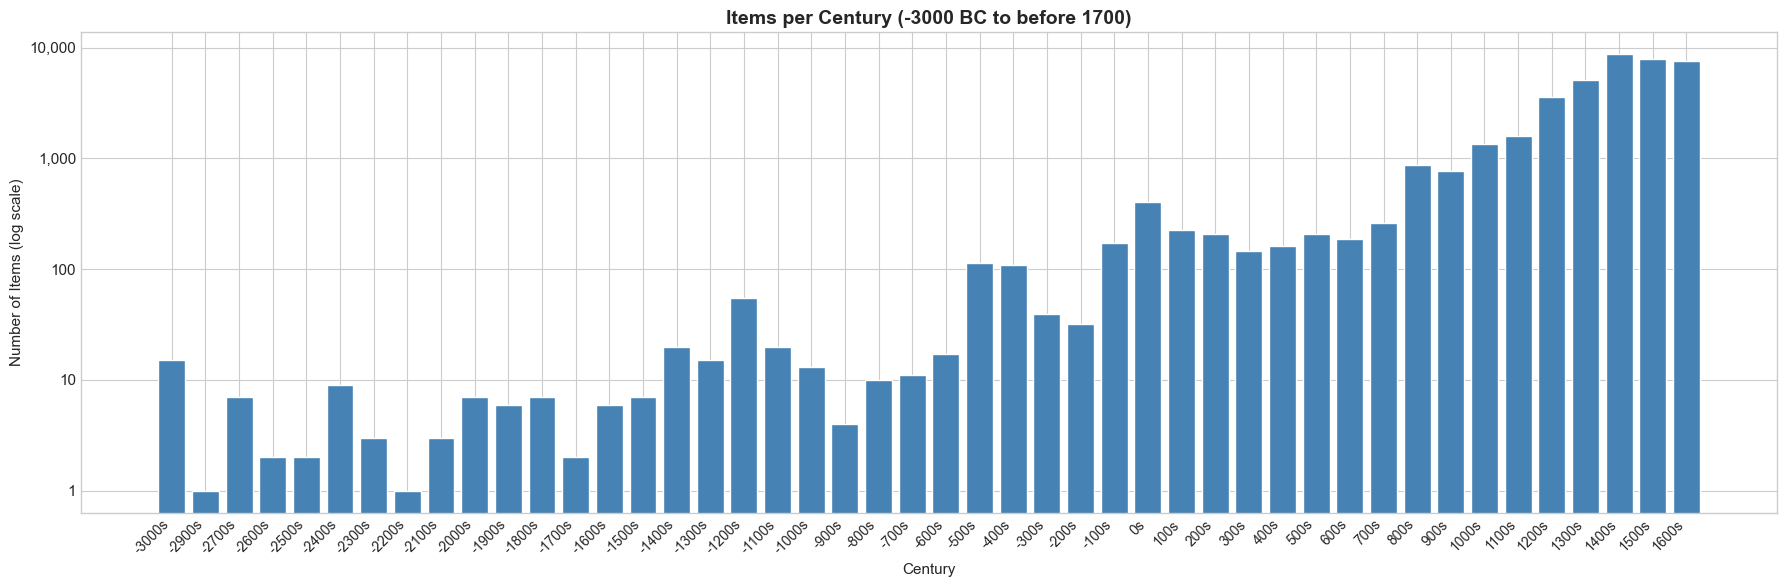

In [3]:
# Items per century
df['century'] = (df['year'] // 100) * 100

counts_century = df.groupby('century').size()

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(range(len(counts_century)), counts_century.values, width=0.8, color='steelblue', edgecolor='white')
ax.set_xlabel('Century')
ax.set_ylabel('Number of Items (log scale)')
ax.set_title('Items per Century (-3000 BC to before 1700)', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticks(range(len(counts_century)))
ax.set_xticklabels([f'{int(x)}s' for x in counts_century.index], rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

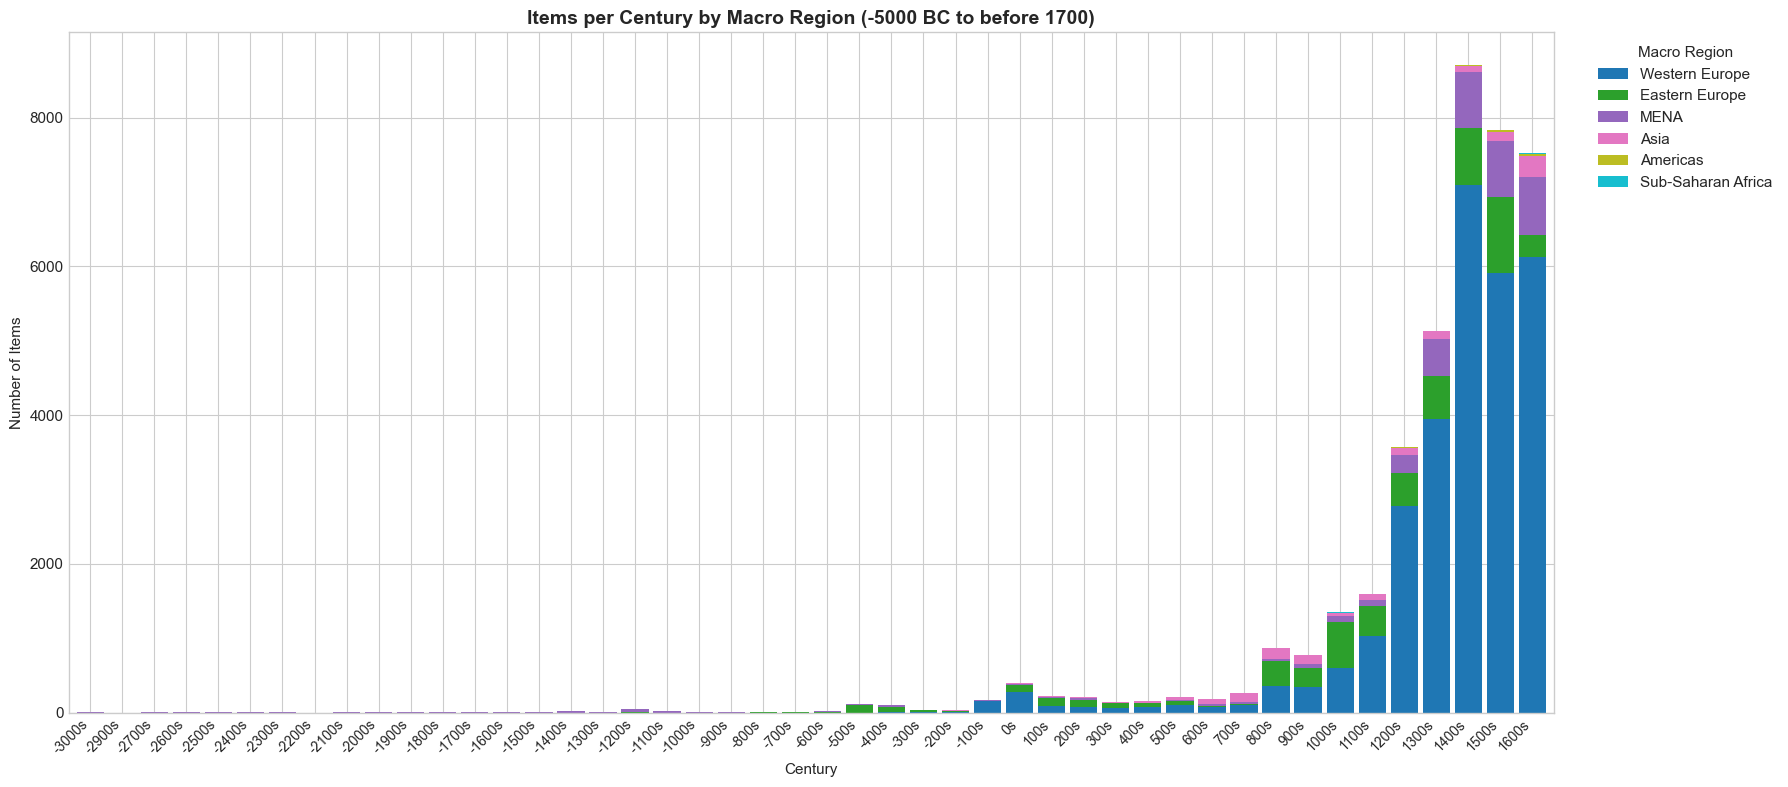

In [4]:
# Stacked bar chart by macro region
timeline = df.groupby(['century', 'macro_region']).size().unstack(fill_value=0)

# Order by total count
region_order = df['macro_region'].value_counts().index.tolist()
timeline = timeline[region_order]

fig, ax = plt.subplots(figsize=(18, 8))
timeline.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.85)
ax.set_xlabel('Century')
ax.set_ylabel('Number of Items')
ax.set_title('Items per Century by Macro Region (-5000 BC to before 1700)', fontsize=14, fontweight='bold')
ax.legend(title='Macro Region', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticks(range(len(timeline.index)))
ax.set_xticklabels([f'{int(x)}s' for x in timeline.index], rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

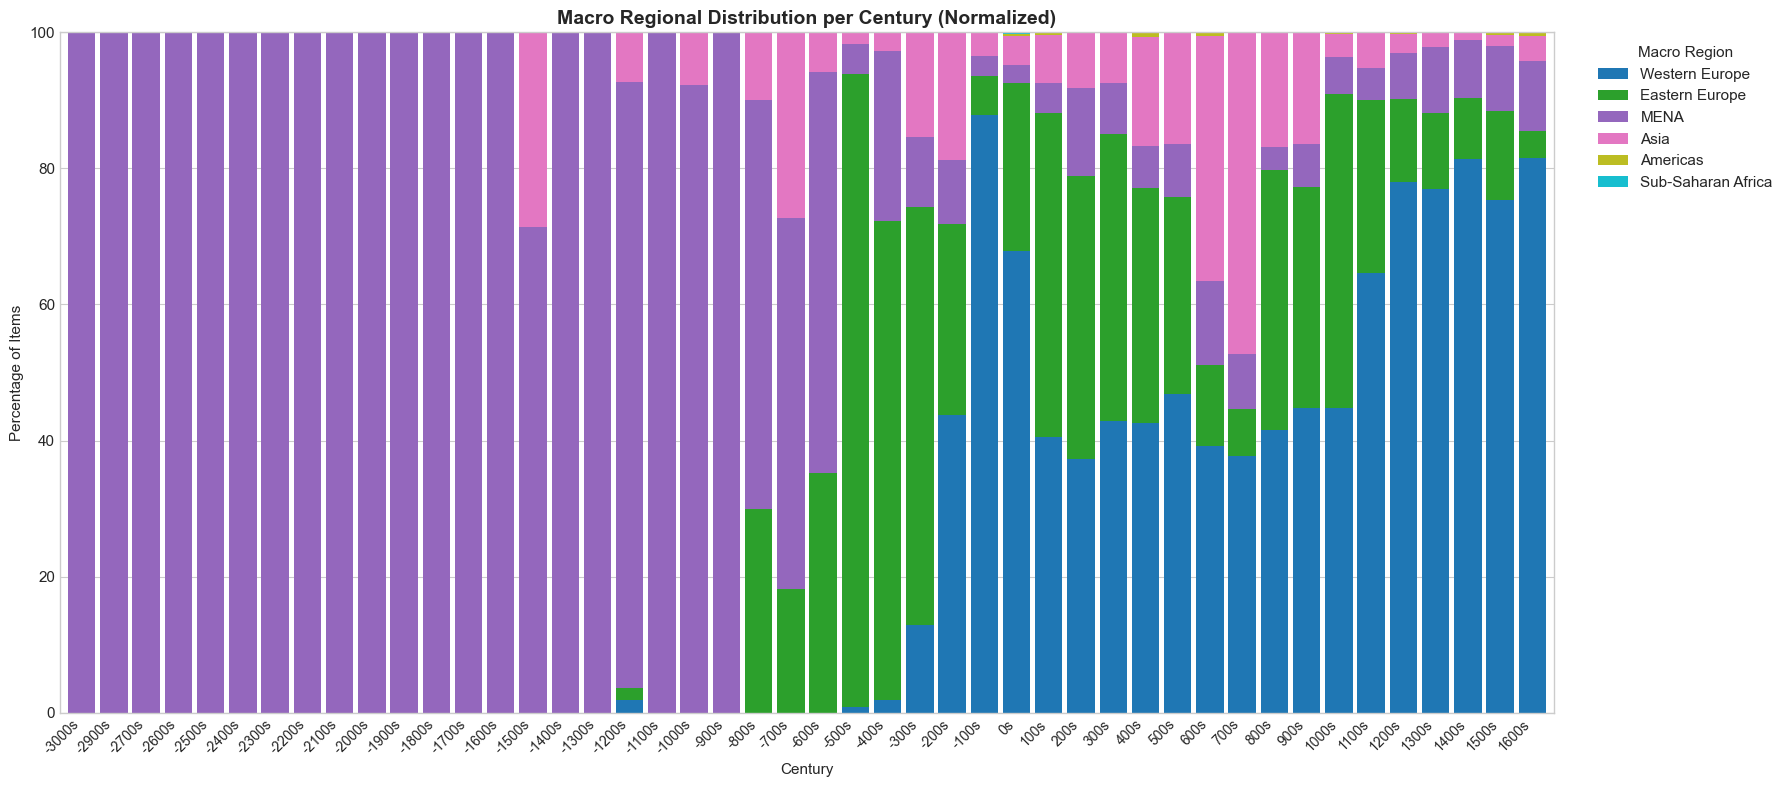

In [5]:
# Normalized stacked bar chart (percentage) - Macro Region
timeline_norm = timeline.div(timeline.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(18, 8))
timeline_norm.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.85)
ax.set_xlabel('Century')
ax.set_ylabel('Percentage of Items')
ax.set_title('Macro Regional Distribution per Century (Normalized)', fontsize=14, fontweight='bold')
ax.legend(title='Macro Region', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticks(range(len(timeline_norm.index)))
ax.set_xticklabels([f'{int(x)}s' for x in timeline_norm.index], rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

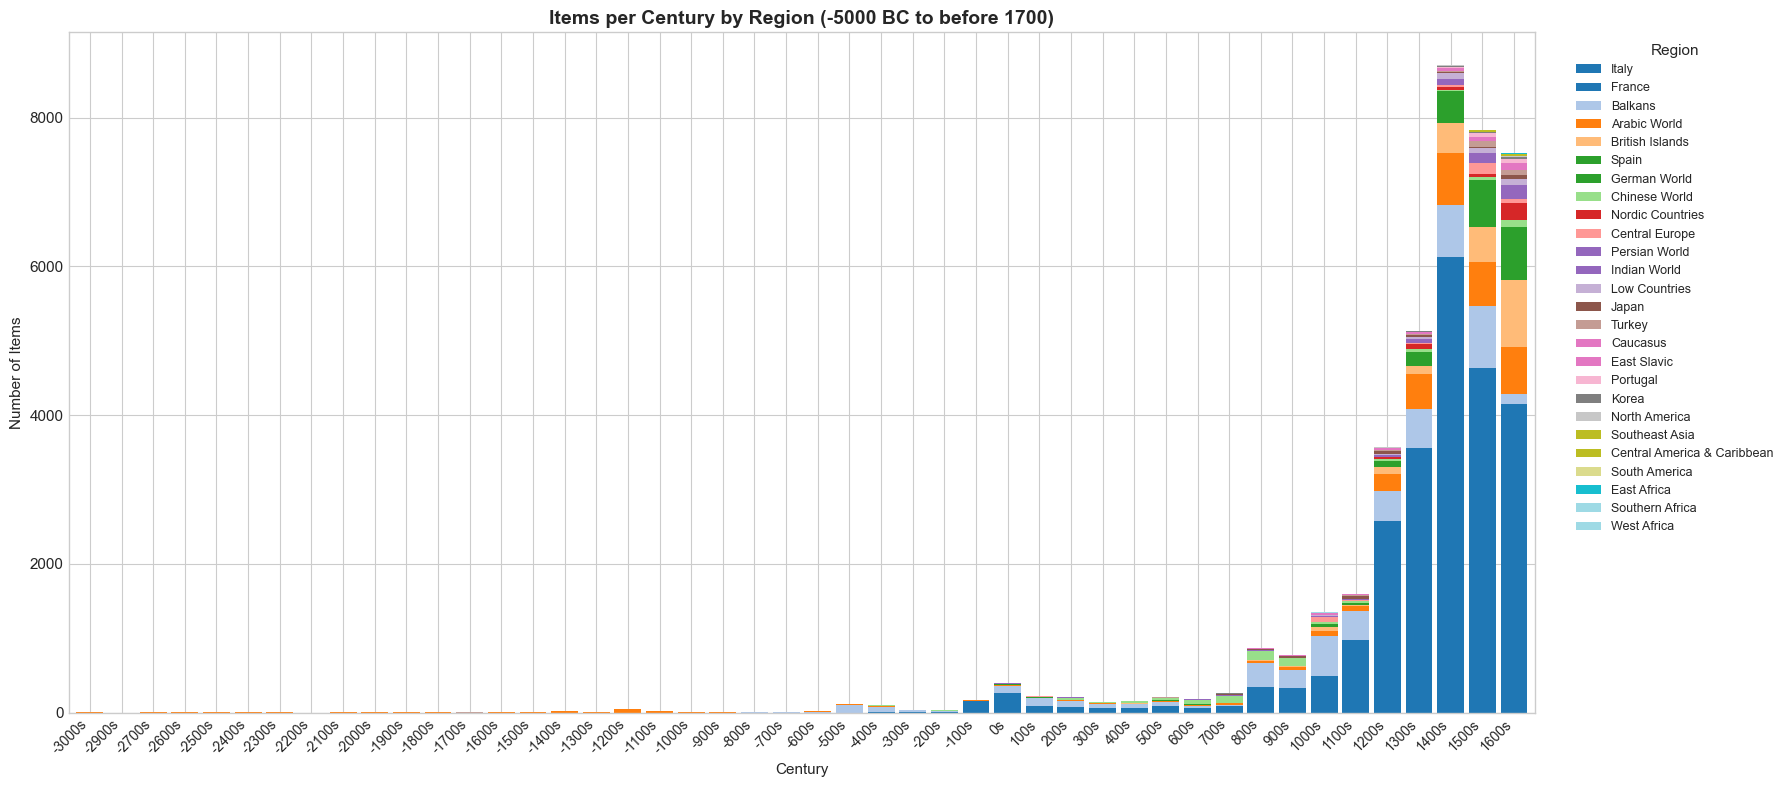

In [6]:
# Stacked bar chart by REGION (detailed)
timeline_region = df.groupby(['century', 'region']).size().unstack(fill_value=0)

# Order by total count
region_detail_order = df['region'].value_counts().index.tolist()
timeline_region = timeline_region[region_detail_order]

fig, ax = plt.subplots(figsize=(18, 8))
timeline_region.plot(kind='bar', stacked=True, ax=ax, colormap='tab20', width=0.85)
ax.set_xlabel('Century')
ax.set_ylabel('Number of Items')
ax.set_title('Items per Century by Region (-5000 BC to before 1700)', fontsize=14, fontweight='bold')
ax.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.set_xticks(range(len(timeline_region.index)))
ax.set_xticklabels([f'{int(x)}s' for x in timeline_region.index], rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

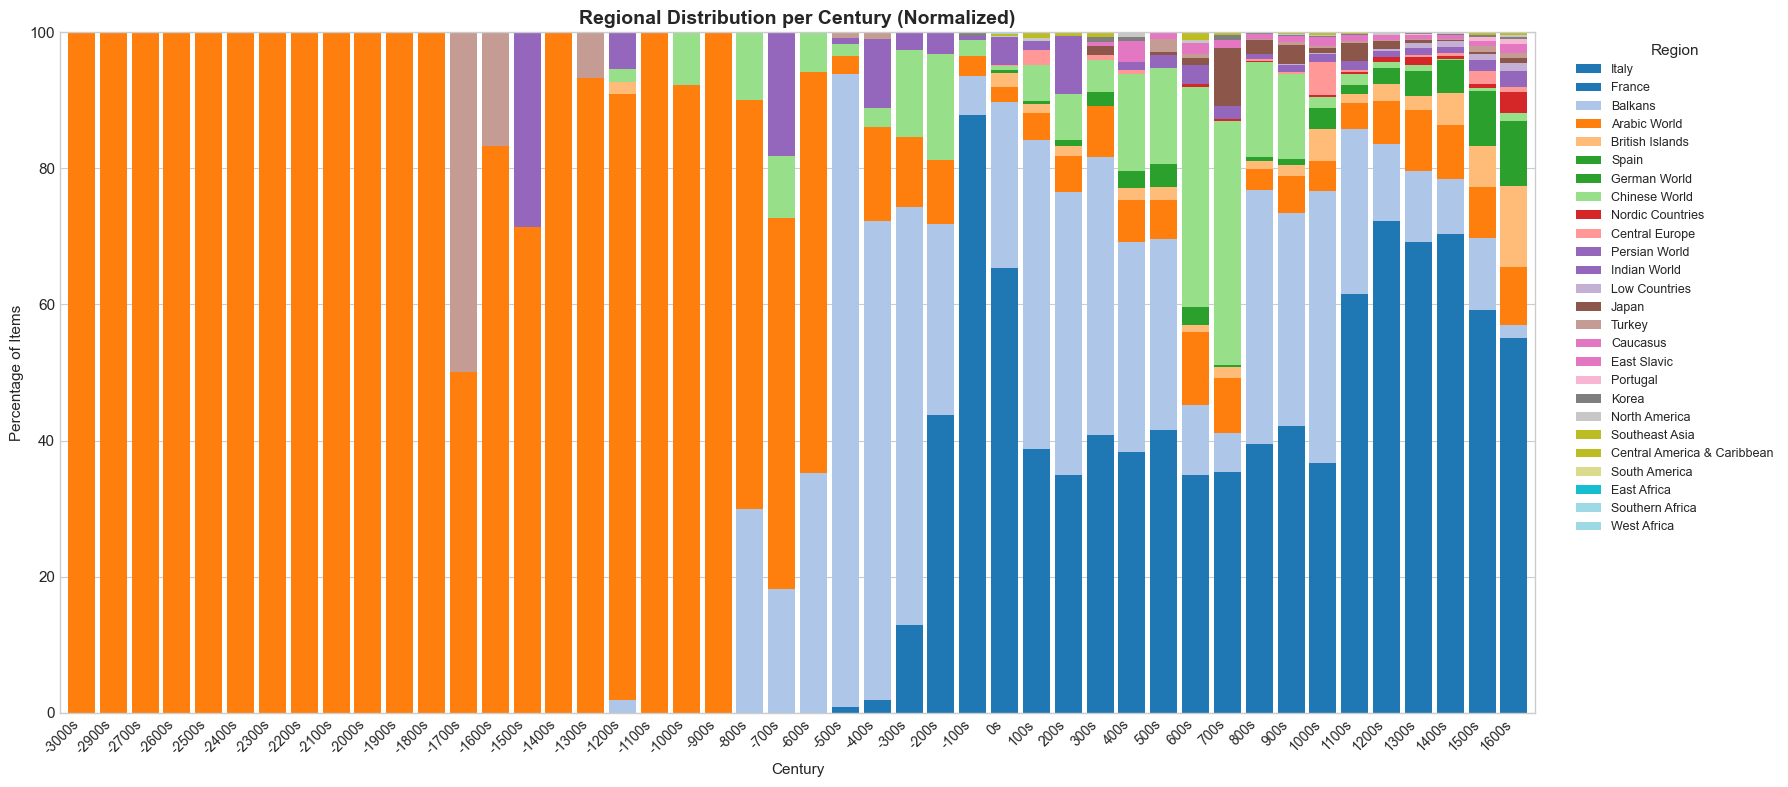

In [7]:
# Normalized stacked bar chart by REGION (percentage)
timeline_region_norm = timeline_region.div(timeline_region.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(18, 8))
timeline_region_norm.plot(kind='bar', stacked=True, ax=ax, colormap='tab20', width=0.85)
ax.set_xlabel('Century')
ax.set_ylabel('Percentage of Items')
ax.set_title('Regional Distribution per Century (Normalized)', fontsize=14, fontweight='bold')
ax.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.set_xticks(range(len(timeline_region_norm.index)))
ax.set_xticklabels([f'{int(x)}s' for x in timeline_region_norm.index], rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

In [8]:
# Summary by macro region
region_summary = df.groupby('macro_region').agg(
    count=('instance_id', 'count'),
    min_year=('year', 'min'),
    max_year=('year', 'max')
).sort_values('count', ascending=False)

region_summary['pct'] = (region_summary['count'] / region_summary['count'].sum() * 100).round(1)
region_summary

,count,min_year,max_year,pct
macro_region,,,,
Western Europe,29217,-1199,1699,73.3
Eastern Europe,5468,-1200,1699,13.7
MENA,3633,-3000,1699,9.1
Asia,1442,-1500,1699,3.6
Americas,94,30,1696,0.2
Sub-Saharan Africa,7,2,1601,0.0


In [9]:
# Top instance type, country, and most referenced work per century
conn = sqlite3.connect(DB_PATH)

query_instances = """
SELECT 
    d.instance_id,
    d.instance_label,
    d.year,
    ip.instance_of,
    ip.sitelinks_count,
    p.modern_country
FROM prop_DATE_consolidated d
JOIN prop_PLACE_consolidated p ON d.instance_id = p.instance_id
JOIN instances_properties ip ON d.instance_id = ip.instance_id
WHERE d.year IS NOT NULL
  AND p.macro_region IS NOT NULL
  AND d.year >= -5000
  AND d.year < 1700
  AND ip.instance_of IS NOT NULL
"""

df_inst = pd.read_sql(query_instances, conn)
conn.close()

df_inst['century'] = (df_inst['year'] // 100) * 100

# For each century, find top instance, top country, and top work from that country
results = []
for century in sorted(df_inst['century'].unique()):
    century_df = df_inst[df_inst['century'] == century]
    total = len(century_df)
    
    # Top instance
    top_instance = century_df['instance_of'].value_counts().head(1)
    instance_name = top_instance.index[0] if len(top_instance) > 0 else None
    instance_pct = round(top_instance.values[0] / total * 100, 1) if len(top_instance) > 0 else 0
    
    # Top country
    top_country = century_df['modern_country'].value_counts().head(1)
    country_name = top_country.index[0] if len(top_country) > 0 else None
    country_pct = round(top_country.values[0] / total * 100, 1) if len(top_country) > 0 else 0
    
    # Most referenced work from TOP COUNTRY (by sitelinks)
    country_df = century_df[century_df['modern_country'] == country_name]
    if len(country_df) > 0 and country_df['sitelinks_count'].notna().any():
        top_work = country_df.loc[country_df['sitelinks_count'].idxmax()]
        work_label = top_work['instance_label']
        work_id = top_work['instance_id']
        work_link = f"https://www.wikidata.org/wiki/{work_id}"
    else:
        work_label, work_link = None, None
    
    results.append({
        'Century': f'{int(century)}s',
        'Items': total,
        'Top Instance': instance_name,
        'Inst %': f'{instance_pct}%',
        'Top Country': country_name,
        'Cty %': f'{country_pct}%',
        'Top Work (from Top Country)': work_label,
        'Wikidata': work_link
    })

top_instances_df = pd.DataFrame(results)
top_instances_df

,Century,Items,Top Instance,Inst %,Top Country,Cty %,Top Work (from Top Country),Wikidata
0,-3000s,15,"stele, archaeological artefact",73.3%,Egypt,93.3%,Stele-E 21711,https://www.wikidata.org/wiki/Q65939239
1,-2900s,1,"creation myth, literary work",100.0%,Iraq,100.0%,Song of the hoe,https://www.wikidata.org/wiki/Q7561191
2,-2700s,7,"papyrus, archaeological find",57.1%,Egypt,100.0%,Stele-E 27157,https://www.wikidata.org/wiki/Q87345363
3,-2600s,2,"archaeological artefact, stele",50.0%,Egypt,100.0%,Funerary meal of chief treasurer Nefer-B 51,https://www.wikidata.org/wiki/Q65083558
4,-2500s,2,"sculpture, stele",50.0%,Iraq,50.0%,Stele of the Vultures,https://www.wikidata.org/wiki/Q1088425
5,-2400s,9,"stele, archaeological artefact",44.4%,Egypt,100.0%,Pyramid Texts,https://www.wikidata.org/wiki/Q645882
6,-2300s,3,"stele, archaeological artefact",66.7%,Egypt,66.7%,Stele of Djati depicting a door-MAHG 023479,https://www.wikidata.org/wiki/Q64211826
7,-2200s,1,inscription,100.0%,Iraq,100.0%,Gudea cylinders,https://www.wikidata.org/wiki/Q5614563
8,-2100s,3,literary work,33.3%,Iraq,66.7%,Epic of Gilgamesh,https://www.wikidata.org/wiki/Q8272
9,-2000s,7,statute,14.3%,Iraq,42.9%,Laws of Eshnunna,https://www.wikidata.org/wiki/Q953024
